In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
lat = {}
lon = {}

lat['Katherine'] = -14.5
lon['Katherine'] = 132.3

lat['Surat'] = -27.2
lon['Surat'] = 149.1

lat['Miena'] = -42.0
lon['Miena'] = 146.7

In [3]:
location = 'Katherine'

### Observations

In [4]:
txx_obs_file = '/Users/irv033/Desktop/unseen-bias/txx_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [5]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [6]:
da_obs = ds_obs['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [7]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=

In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
2020-06-30 00:00:00 -15.0  131.5  2019-12-06  43.400116
1963-06-30 00:00:00 -15.0  131.5  1962-11-14  42.760883
2007-06-30 00:00:00 -15.0  131.5  2006-11-15  41.986866
1960-06-30 00:00:00 -15.0  131.5  1959-11-18  41.640137
2003-06-30 00:00:00 -15.0  131.5  2002-10-23  41.511543
2022-06-30 00:00:00 -15.0  131.5  2021-10-21  41.474518
2015-06-30 00:00:00 -15.0  131.5  2014-10-30  41.461330
2019-06-30 00:00:00 -15.0  131.5  2018-10-30  41.429077
2005-06-30 00:00:00 -15.0  131.5  2004-12-14  41.414959
2023-06-30 00:00:00 -15.0  131.5  2022-12-09  41.414898


In [10]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [11]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [12]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

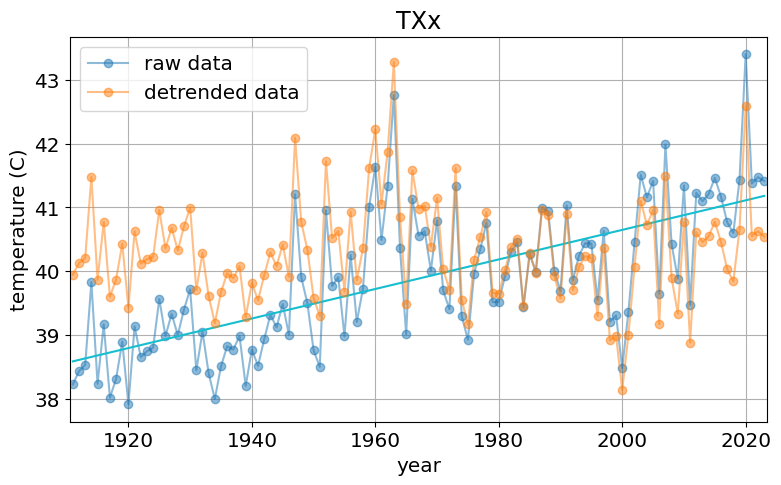

In [13]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [14]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: 0.14
Location parameter: 39.98
Scale parameter: 0.74


### Model data

In [15]:
txx_model_file = '/Users/irv033/Desktop/unseen-bias/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [16]:
ds_model = fileio.open_dataset(txx_model_file)

In [17]:
da_model = ds_model['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [18]:
da_model = da_model.compute()

In [19]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [21]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [22]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [23]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [24]:
da_model_detrended = da_model_detrended_stacked.unstack()

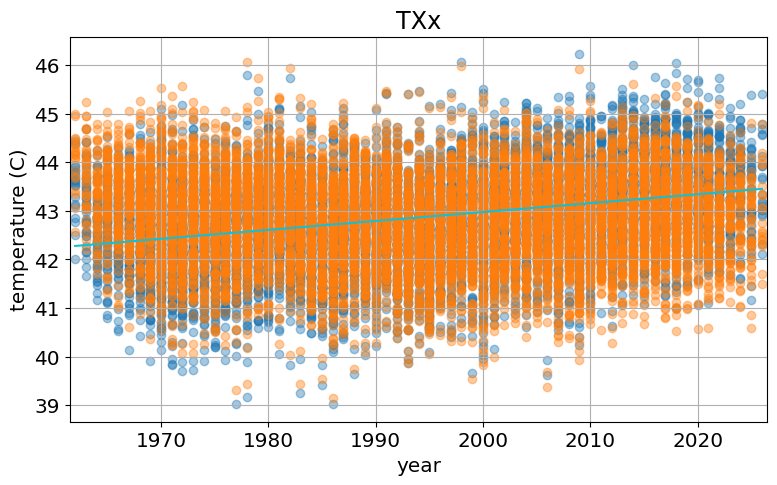

In [25]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


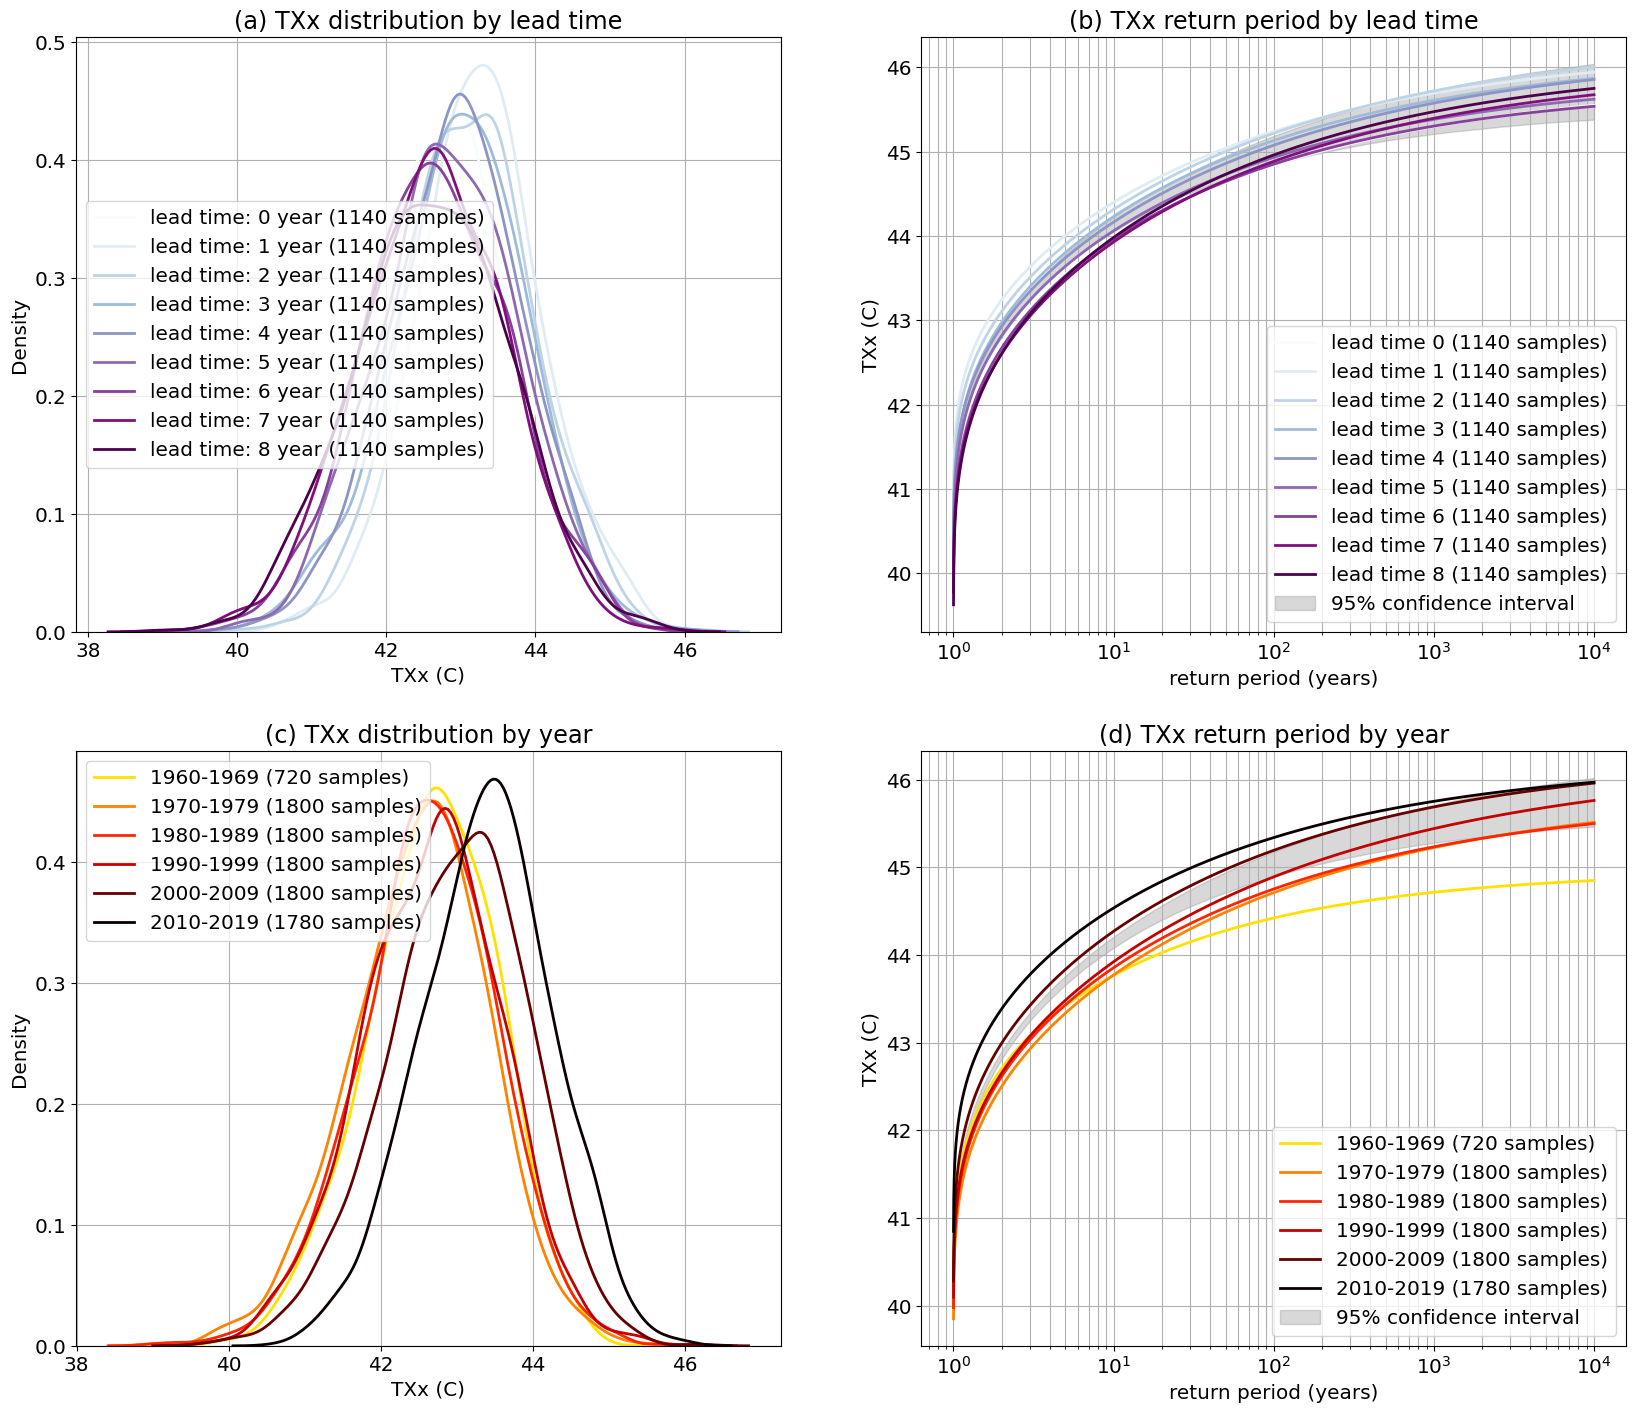

In [26]:
stability.create_plot(
    da_model,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


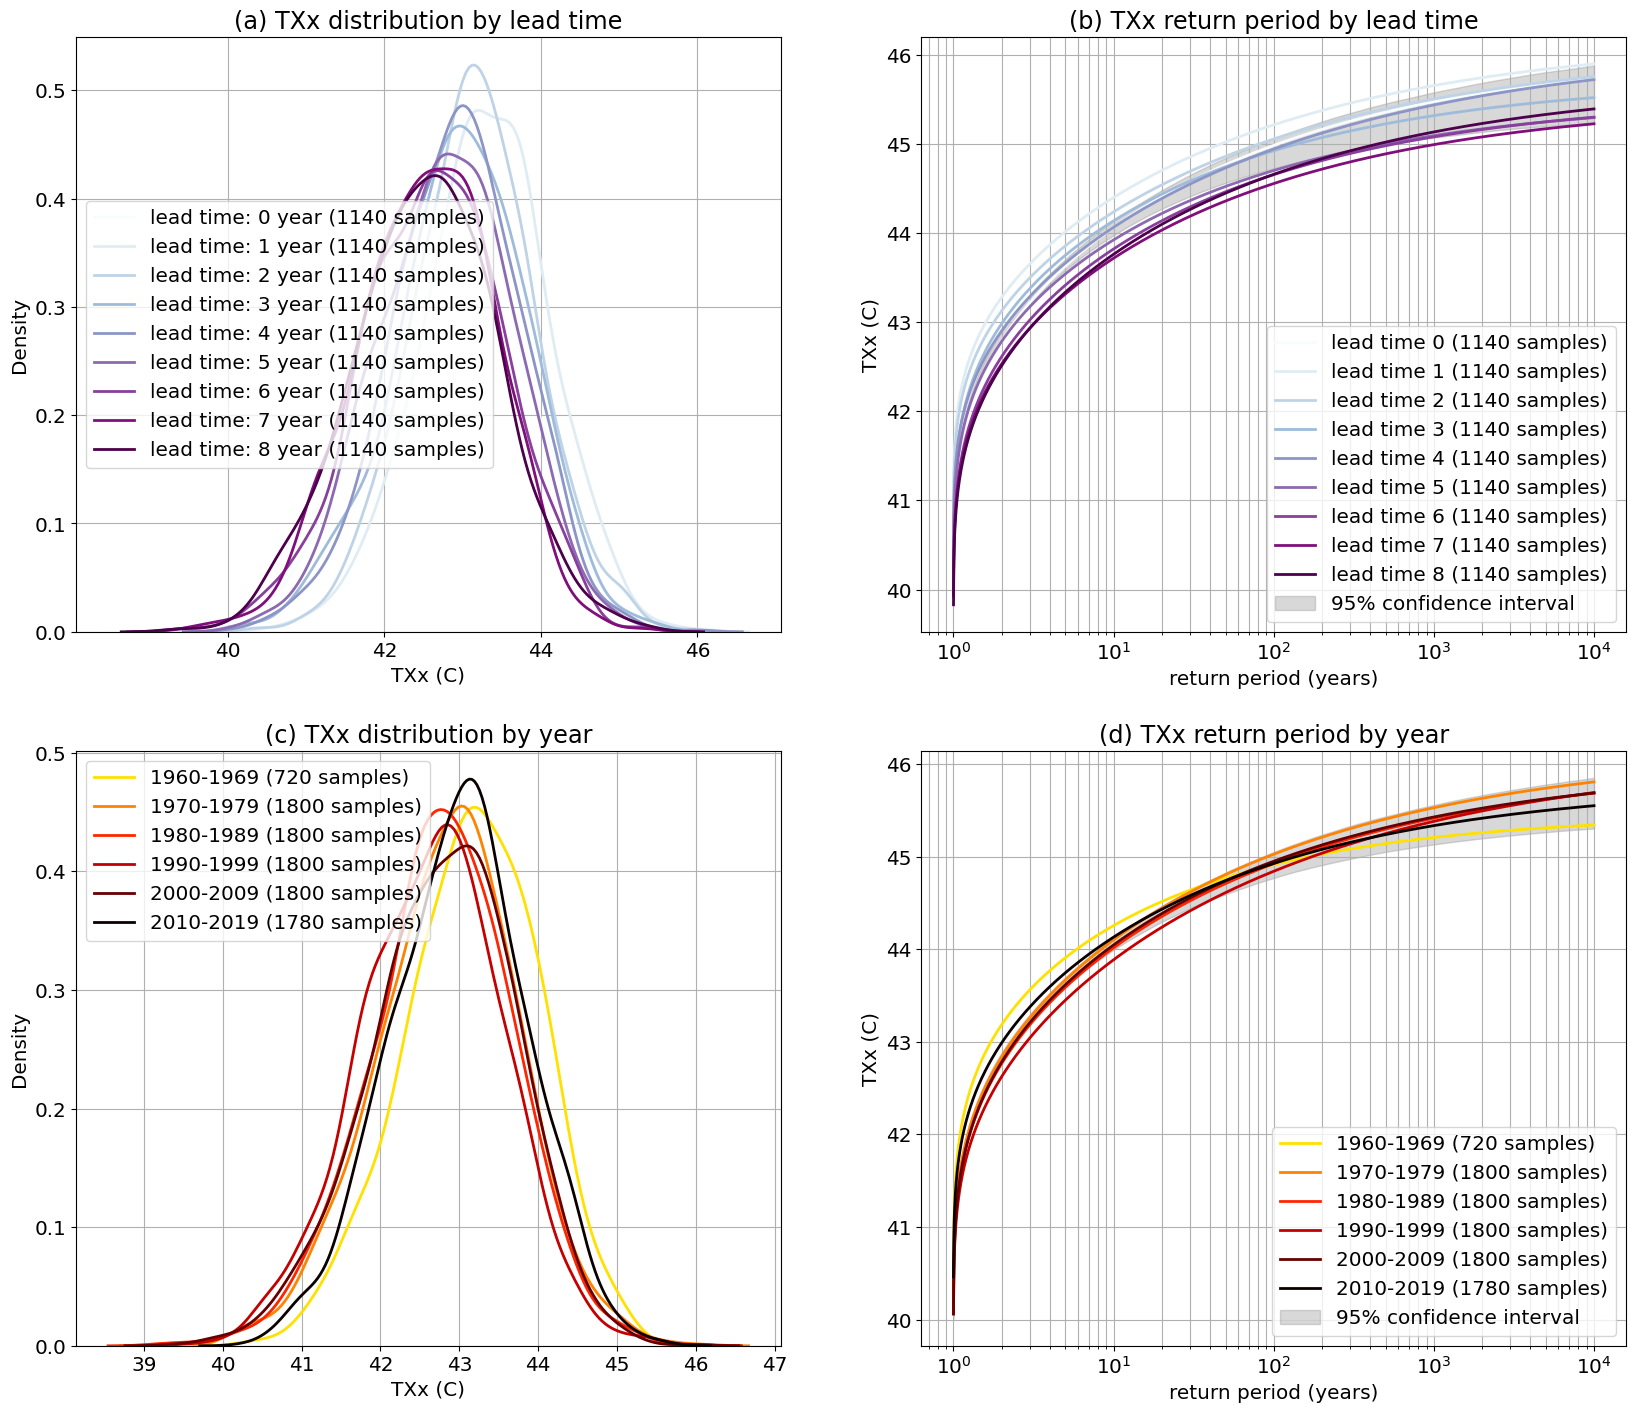

In [27]:
stability.create_plot(
    da_model_detrended,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

In [28]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.26
Location parameter: 42.51
Scale parameter: 0.92


### Mean correction

#### Additive

In [29]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [30]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [31]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [32]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [33]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.26
Location parameter: 39.79
Scale parameter: 0.92


#### Multiplicative

In [34]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [35]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'multiplicative')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [36]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [37]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.26
Location parameter: 39.81
Scale parameter: 0.86


### Quantile correction

In [38]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [39]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [40]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)

# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [41]:
da_model_detrended_q.values

array([41.30236585, 41.90333893, 42.2513446 , 42.52794183, 42.76632151,
       42.9937793 , 43.21193286, 43.4571961 , 43.76481886, 44.26417413])

In [42]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)

# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [43]:
da_obs_detrended_q.values

array([39.1658982 , 39.57397084, 39.82063032, 39.96963798, 40.18167549,
       40.35972228, 40.54062996, 40.76971334, 40.96385591, 41.65968585])

In [44]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [45]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

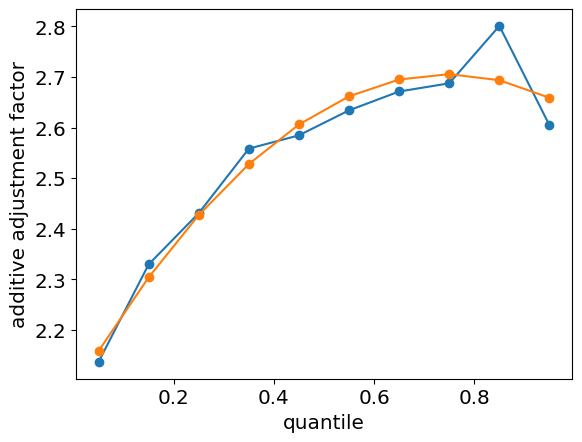

In [46]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [47]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [48]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

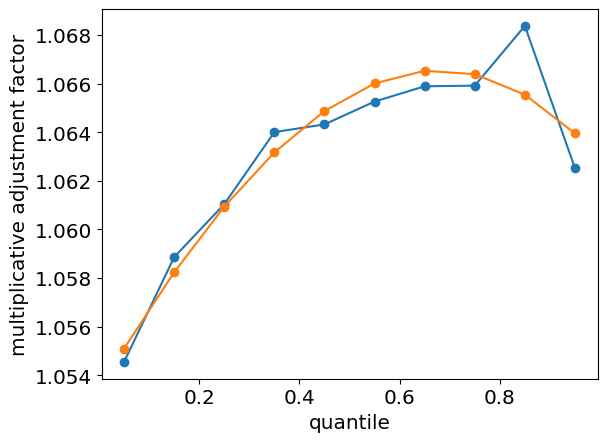

In [49]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [50]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [51]:
#af_add = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_add,
#)
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [52]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [53]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: 0.20
Location parameter: 40.01
Scale parameter: 0.73


#### Multiplicative

In [54]:
#af_mulc = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_mulc,
#)
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [55]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [56]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: 0.21
Location parameter: 40.01
Scale parameter: 0.72


## Comparison

In [57]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [58]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

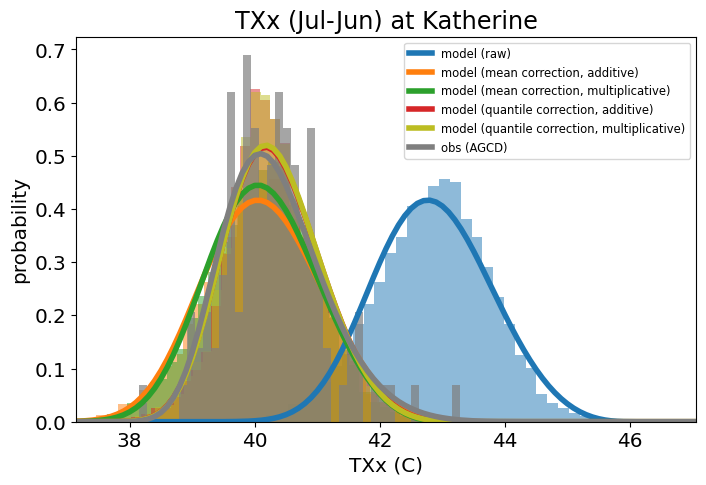

In [59]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(20, 65, 0.1)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at {location}')

plt.xlim(xmin, xmax)
plt.legend(fontsize='small')
plt.savefig(f'txx_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

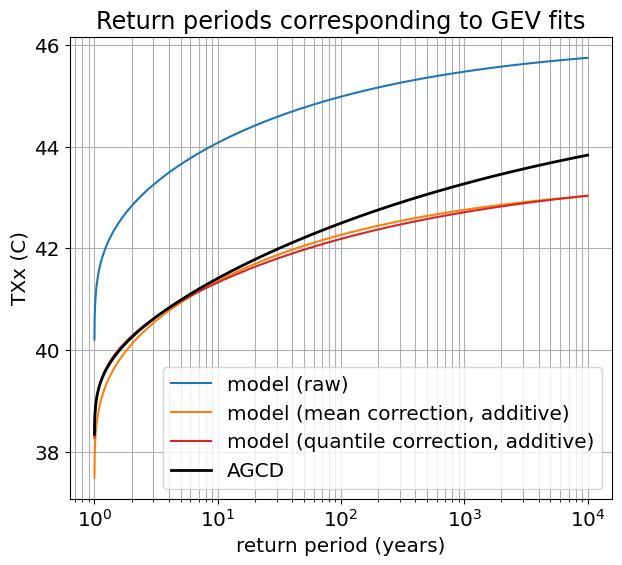

In [60]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_add, color='tab:orange', label='model (mean correction, additive)')
return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add = stability.return_curve(
    da_model_detrended_bc_mean_add,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add],
)
ax2.plot(return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add, label='model (mean correction, additive)', color='tab:orange')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_add, color='tab:red', label='model (quantile correction, additive)')
return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add = stability.return_curve(
    da_model_detrended_bc_quantile_add,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add],
)
ax2.plot(return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add, label='model (quantile correction, additive)', color='tab:red')

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('TXx (C)')
ax2.set_title('Return periods corresponding to GEV fits')
#ax2.set_ylim([0, 700])
ax2.grid(which='both')
plt.savefig(f'txx_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [61]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.8660077
KS p-value: 0.0
AD score: 434.11716
AD p-value: 0.001


### Additive - mean correction

KS score: 0.19916335
KS p-value: 0.00022750611
AD score: 9.321127
AD p-value: 0.001


INFO:root:mean: Obs = 40.307415008544886, Model 95% CI =42.679133734874476 to 43.00095171249742
INFO:root:standard deviation: Obs = 0.8019073938421447, Model 95% CI =0.7799678440622482 to 1.012793799948935
INFO:root:skew: Obs = 0.6330449854734574, Model 95% CI =-0.652149388568188 to 0.2629661667000076
INFO:root:kurtosis: Obs = 1.3713468508770816, Model 95% CI =-0.7026899038067492 to 1.2318654470501964
INFO:root:GEV shape: Obs = 0.1373700941505394, Model 95% CI =0.19669013101315944 to 0.46547514742431767
INFO:root:GEV location: Obs = 39.98041745707976, Model 95% CI =42.36191195316582 to 42.72376989793362
INFO:root:GEV scale: Obs = 0.7370179655674103, Model 95% CI =0.7873701947021166 to 1.0449450453485654
INFO:root:mean: Obs = 40.307415008544886, Bias corrected model 95% CI =39.94146527642859 to 40.277170404366025
INFO:root:standard deviation: Obs = 0.8019073938421447, Bias corrected model 95% CI =0.7765889438148968 to 1.0181095290952382
INFO:root:skew: Obs = 0.6330449854734574, Bias cor

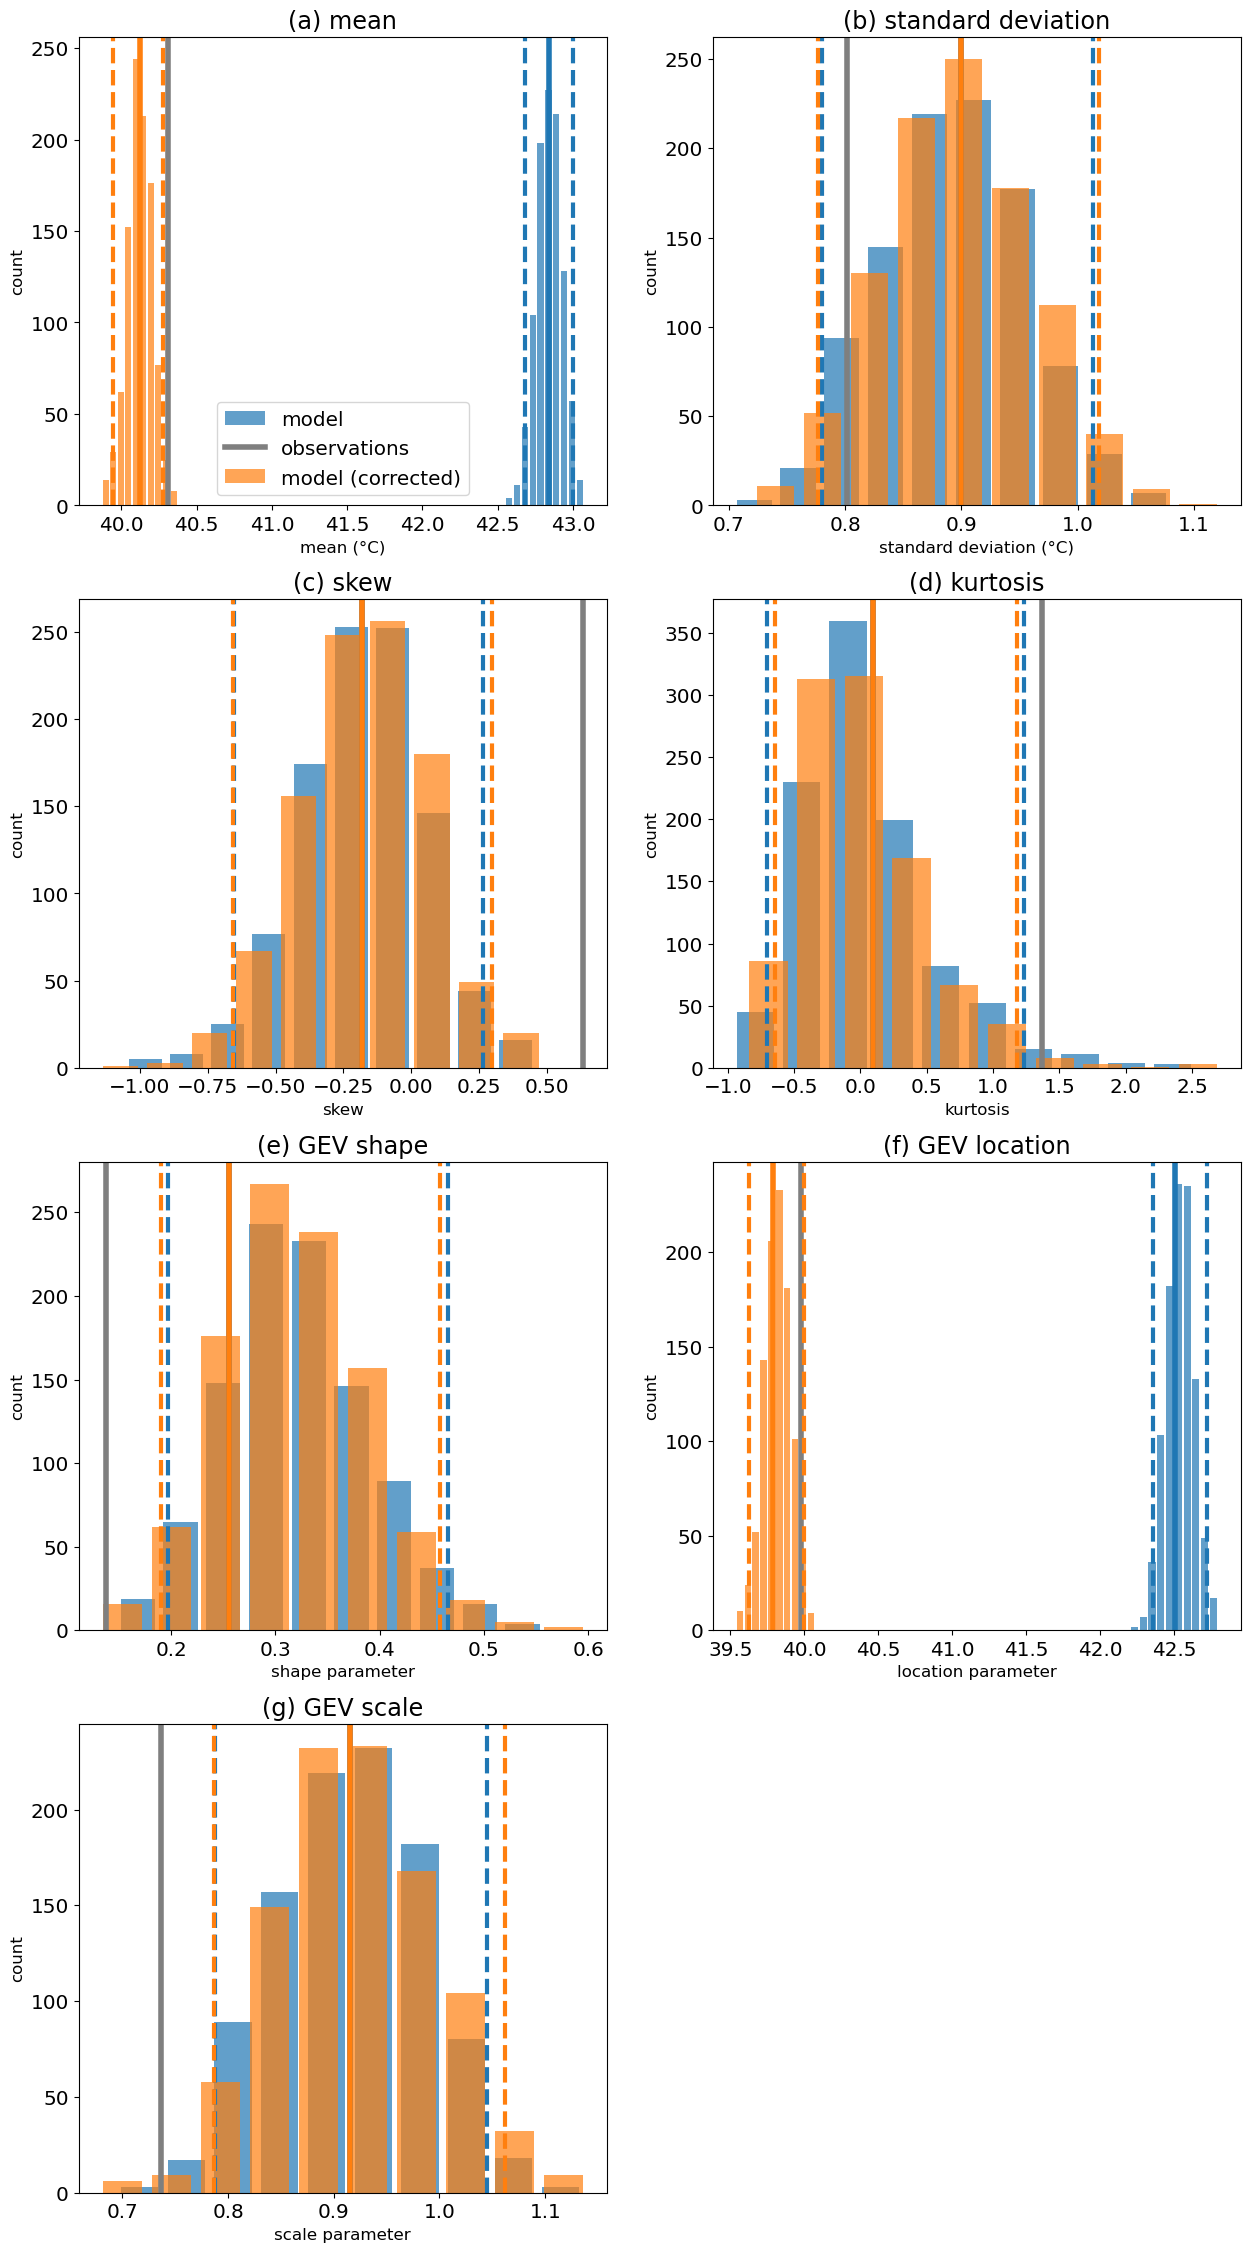

In [62]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.21115164
KS p-value: 7.354996e-05
AD score: 11.862779
AD p-value: 0.001


INFO:root:mean: Obs = 40.307415008544886, Model 95% CI =42.67897621131916 to 43.00164298301006
INFO:root:standard deviation: Obs = 0.8019073938421447, Model 95% CI =0.7709558301743895 to 1.01639216642994
INFO:root:skew: Obs = 0.6330449854734574, Model 95% CI =-0.5941657134650864 to 0.2650693105255592
INFO:root:kurtosis: Obs = 1.3713468508770816, Model 95% CI =-0.6686396597408922 to 1.150004090863826
INFO:root:GEV shape: Obs = 0.1373700941505394, Model 95% CI =0.19478279841515167 to 0.4555780186078339
INFO:root:GEV location: Obs = 39.98041745707976, Model 95% CI =42.36137250469525 to 42.725746616544335
INFO:root:GEV scale: Obs = 0.7370179655674103, Model 95% CI =0.7628844204752943 to 1.0569827671129333
INFO:root:mean: Obs = 40.307415008544886, Bias corrected model 95% CI =39.96488241286731 to 40.270555873814814
INFO:root:standard deviation: Obs = 0.8019073938421447, Bias corrected model 95% CI =0.7367677380713459 to 0.9488851019913751
INFO:root:skew: Obs = 0.6330449854734574, Bias corre

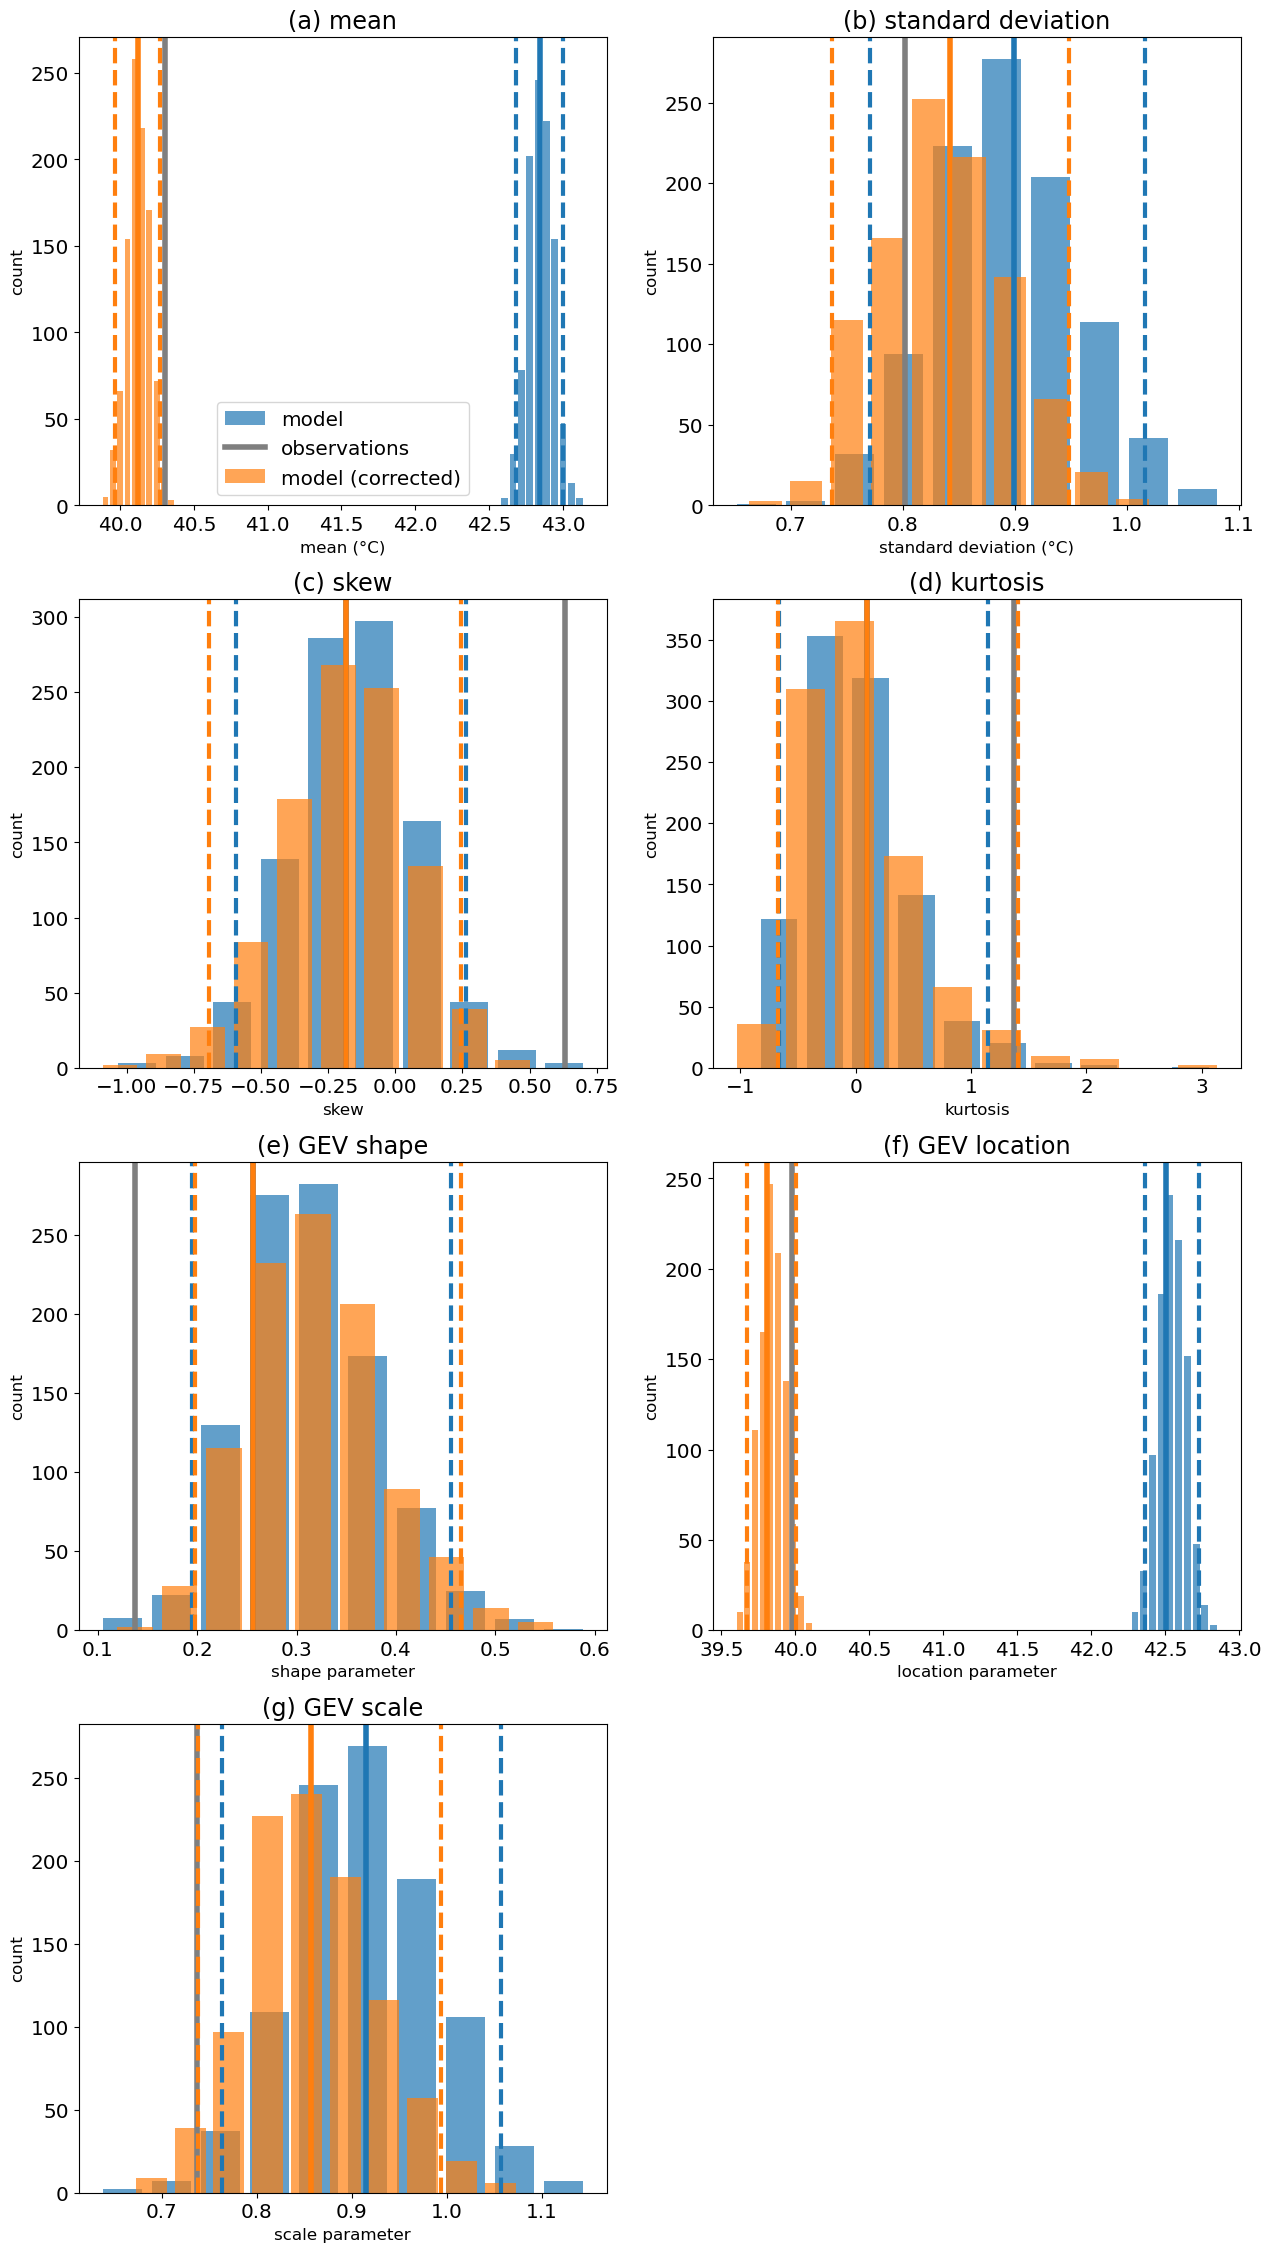

In [63]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.3224577
KS p-value: 7.295375e-11
AD score: 36.872887
AD p-value: 0.001


INFO:root:mean: Obs = 40.307415008544886, Model 95% CI =42.68901976188888 to 43.01014081001228
INFO:root:standard deviation: Obs = 0.8019073938421447, Model 95% CI =0.7638641071111236 to 1.0159479028156893
INFO:root:skew: Obs = 0.6330449854734574, Model 95% CI =-0.6528959231742254 to 0.2802221125759865
INFO:root:kurtosis: Obs = 1.3713468508770816, Model 95% CI =-0.6781073918370151 to 1.2938380542232581
INFO:root:GEV shape: Obs = 0.1373700941505394, Model 95% CI =0.19248410585651476 to 0.4607266965046695
INFO:root:GEV location: Obs = 39.98041745707976, Model 95% CI =42.36810459575018 to 42.71766471520993
INFO:root:GEV scale: Obs = 0.7370179655674103, Model 95% CI =0.7685858128651738 to 1.056309437285404
INFO:root:mean: Obs = 40.307415008544886, Bias corrected model 95% CI =40.15430745164727 to 40.436724746553054
INFO:root:standard deviation: Obs = 0.8019073938421447, Bias corrected model 95% CI =0.6348937763338053 to 0.8573902346539194
INFO:root:skew: Obs = 0.6330449854734574, Bias corr

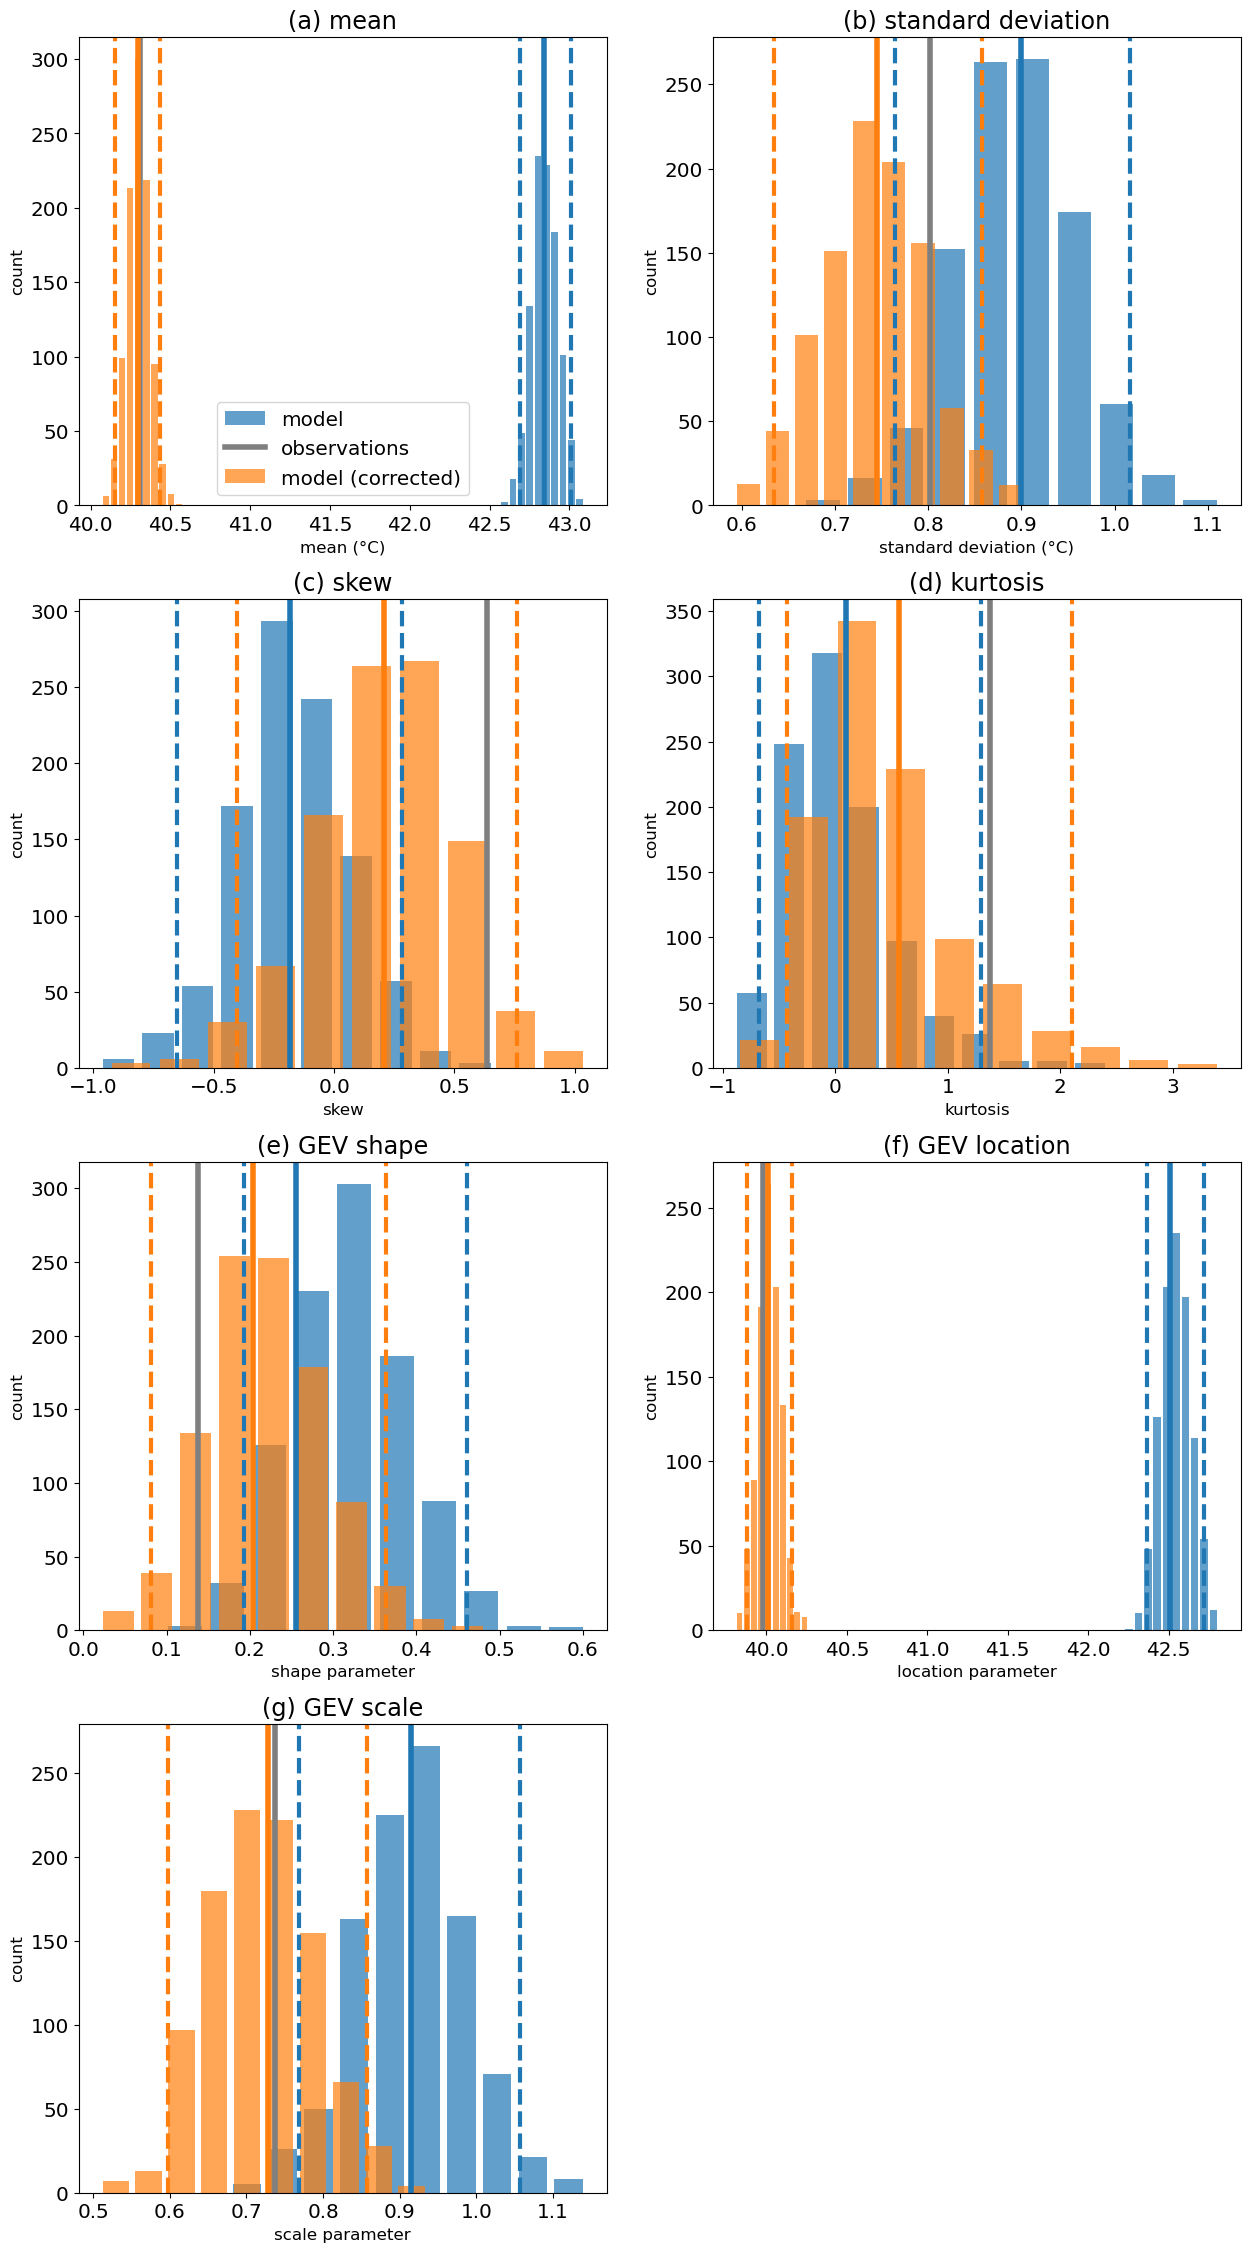

In [64]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.32138556
KS p-value: 8.585518e-11
AD score: 37.206387
AD p-value: 0.001


INFO:root:mean: Obs = 40.307415008544886, Model 95% CI =42.67934852846186 to 43.00021711762241
INFO:root:standard deviation: Obs = 0.8019073938421447, Model 95% CI =0.7771199842908779 to 1.008794429805636
INFO:root:skew: Obs = 0.6330449854734574, Model 95% CI =-0.6587431209887955 to 0.27262081308393726
INFO:root:kurtosis: Obs = 1.3713468508770816, Model 95% CI =-0.6860266418761473 to 1.1544058144030522
INFO:root:GEV shape: Obs = 0.1373700941505394, Model 95% CI =0.19613027514803683 to 0.45904543123435093
INFO:root:GEV location: Obs = 39.98041745707976, Model 95% CI =42.36467707400531 to 42.7217025394713
INFO:root:GEV scale: Obs = 0.7370179655674103, Model 95% CI =0.7862093674061503 to 1.053792407594761
INFO:root:mean: Obs = 40.307415008544886, Bias corrected model 95% CI =40.1603067465098 to 40.43696068981831
INFO:root:standard deviation: Obs = 0.8019073938421447, Bias corrected model 95% CI =0.6336885343225357 to 0.8433660257380636
INFO:root:skew: Obs = 0.6330449854734574, Bias correc

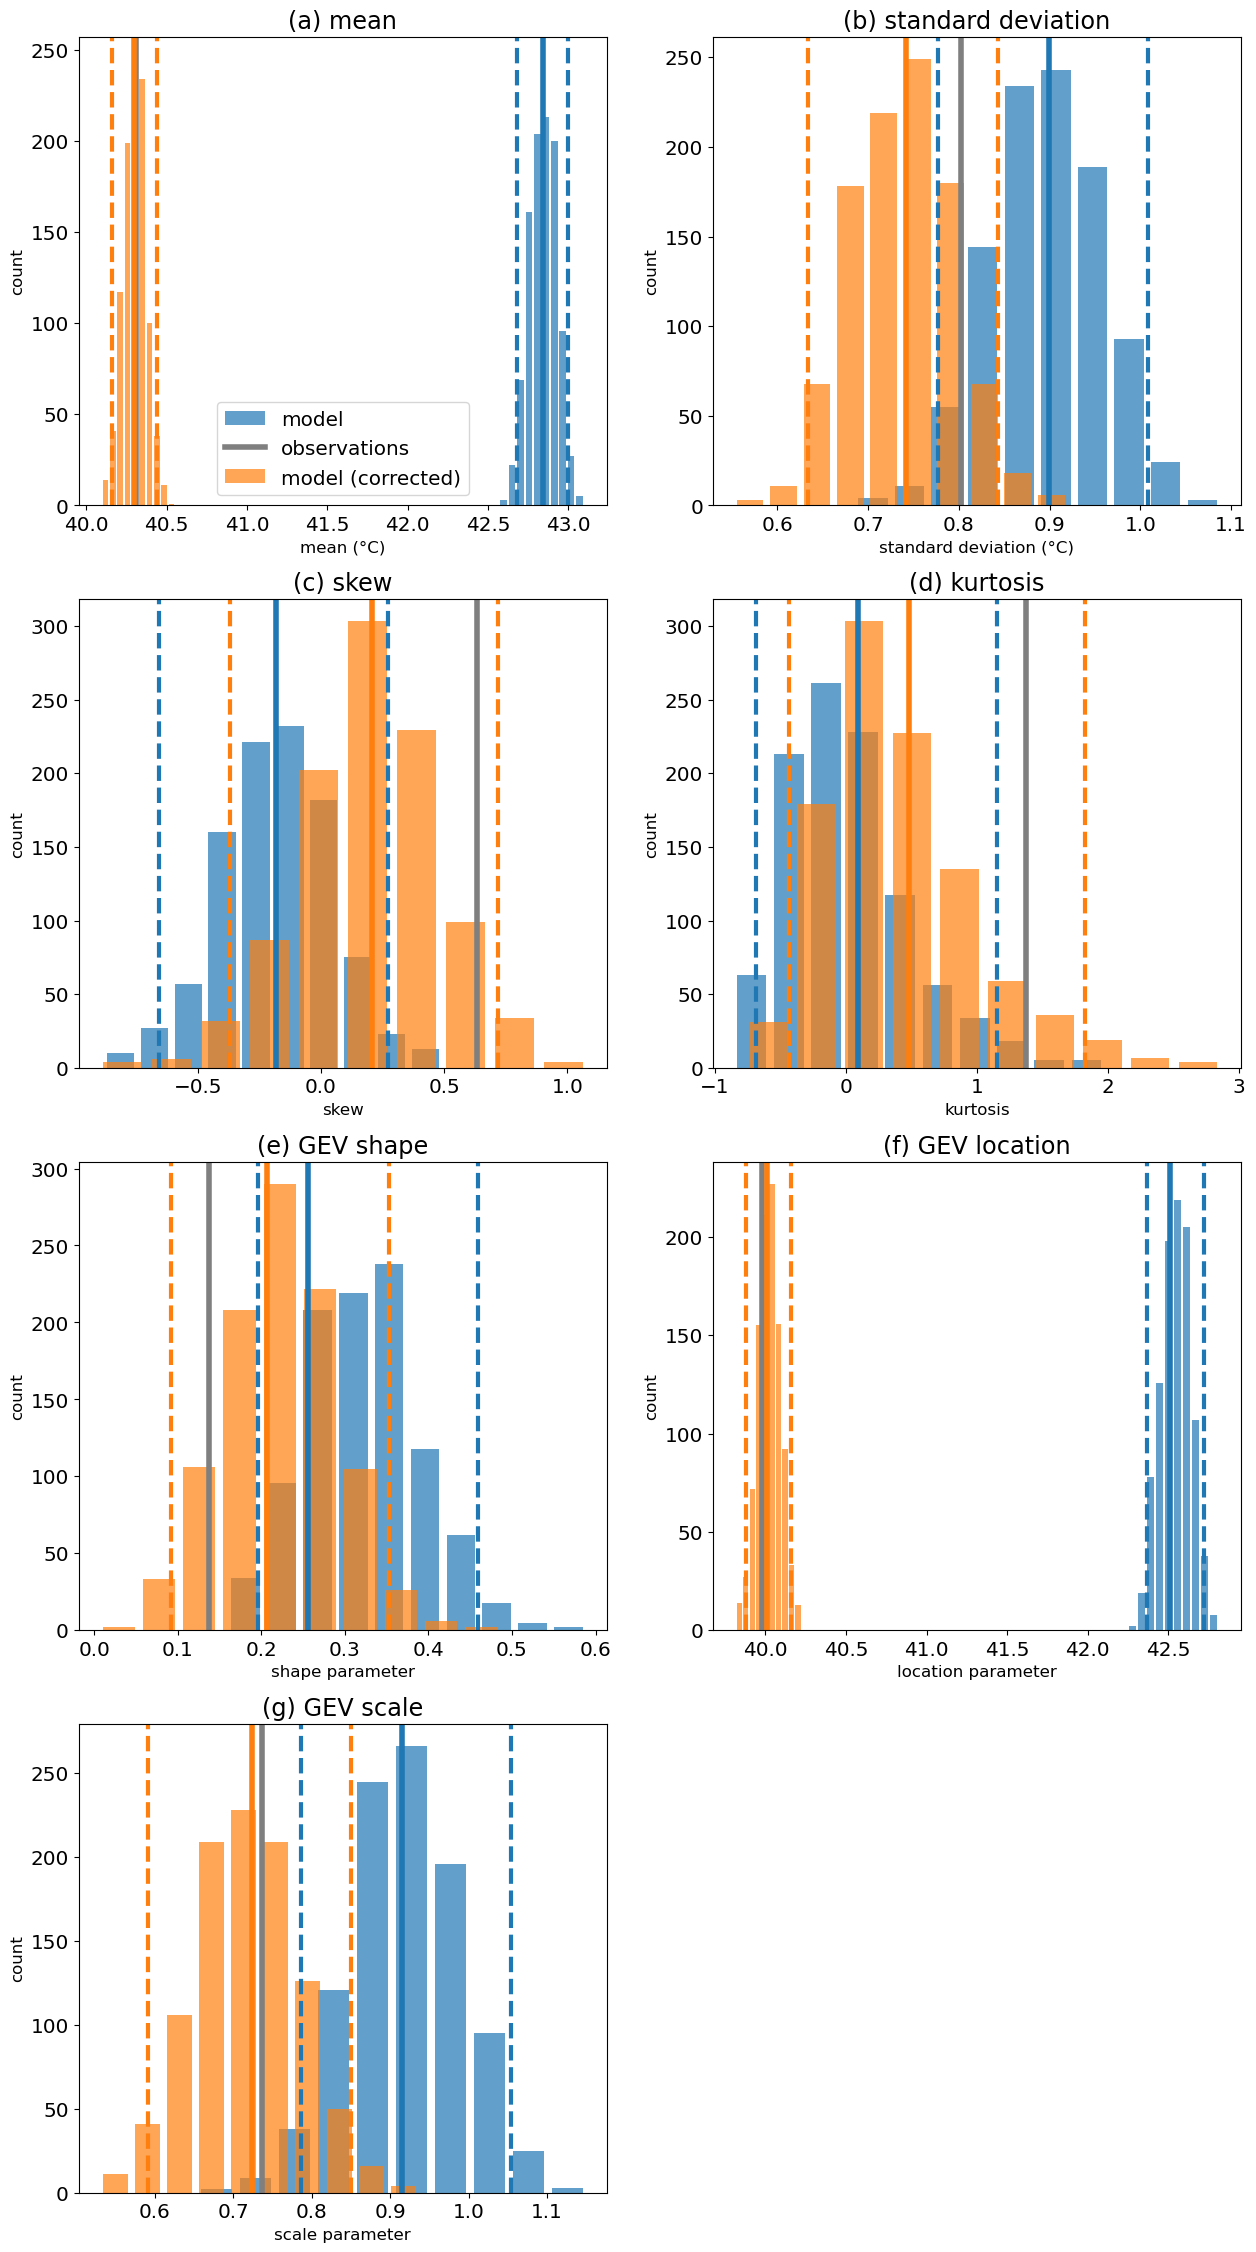

In [65]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())